In [ ]:
# There is a strange peak in some shots, whats happening there ?

In [1]:
import pickle
from read_lapd import read_lapd_data
from bdot_process import emf2bw_areav
import numpy as np
import matplotlib.pyplot as plt
import pyspedas
from matplotlib import ticker, colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
from bdot_process import emf2bw
import os

datapath = '/data/BAPSF_Data/Energetic_Electron_Ring/jul2021/'
filename = '04-bfield-p25-plane-He-1kG-uwave-l5ms-mirror-min-305G.hdf5'

In [2]:

filepath = datapath + filename

data = read_lapd_data(filepath, rchan=[0, 1, 2], rshot=[6], xrange=[20], yrange=[8])

# Not sure how to get this one, remember to ask Xin!

area = [1.889e-1, 1.843e-1, 1.501e-1]

fs = 1.0 / data['dt'][0]
lowcut = 1.5e8
highcut = 1e9
bx = emf2bw(np.squeeze(data['data'])[:, 0], area[0], \
        lowcut, highcut, fs, rm_radio=1)
by = emf2bw(np.squeeze(data['data'])[:, 1], area[1], \
        lowcut, highcut, fs, rm_radio=1)
bz = emf2bw(np.squeeze(data['data'])[:, 2], area[2], \
        lowcut, highcut, fs, rm_radio=1)
# bx = emf2bw_areav(np.squeeze(data['data'])[:, 0], areav[0], \
#         lowcut, highcut, fs, rm_radio=1)
# by = emf2bw_areav(np.squeeze(data['data'])[:, 1], areav[1], \
#         lowcut, highcut, fs, rm_radio=1)
# bz = emf2bw_areav(np.squeeze(data['data'])[:, 2], areav[2], \
#         lowcut, highcut, fs, rm_radio=1)

# truncate time series at the beginning and end sections
ntrunc = 100
bx = bx[ntrunc:-ntrunc]
by = by[ntrunc:-ntrunc]
bz = bz[ntrunc:-ntrunc]
tt = data['time'][ntrunc:-ntrunc]

Reading data from motion list XY[2]: Ta_paddle
Reading motion list from module:  6K Compumotor
No 3302 boards used.
SIS 3305 boards used = [1, 2]
SIS 3305 effective clock rate: Board 1 = 5000.0 MHz
SIS 3305 effective clock rate: Board 2 = 5000.0 MHz
---------- SIS 3305 list of enabled channels (4) ----------
[ 0] Board 1, Channel 1: Bx-P25mov
[ 1] Board 1, Channel 5: By-P25mov
[ 2] Board 2, Channel 1: Bz-P25mov
[ 3] Board 2, Channel 5: By-P26fxd
------------------------------------------------------------
Reading SIS 3305...
------------------------------------------------------------
Data geometry = xy-plane
Read Channels = 0   1   2
Shot range    = 6 to 6
X value range = 20 to 20
Y value range = 8 to 8
 (xx/yy/zz/shots/steps/chan) = (1/1/1/1/1/1) of (1/1/1/1/1/3)1 1
Reading config name /Raw data + config/SIS crate/siscf0-4ch-5GHz-1Mpnts-200us [Slot 13: SIS 3305 FPGA 1 ch 1]
 (xx/yy/zz/shots/steps/chan) = (1/1/1/1/1/2) of (1/1/1/1/1/3)1 5
Reading config name /Raw data + config/SIS cra

04-Apr-24 11:30:41: /home/dma24/EER_LAPD/bdot_process.py:36: RuntimeWarning: divide by zero encountered in divide
  Bw_fft = emf_fft * (1e-2/3) / (-2.0j * const.pi * freq) / area * (c_cgs)

04-Apr-24 11:30:41: /home/dma24/EER_LAPD/bdot_process.py:36: RuntimeWarning: invalid value encountered in divide
  Bw_fft = emf_fft * (1e-2/3) / (-2.0j * const.pi * freq) / area * (c_cgs)



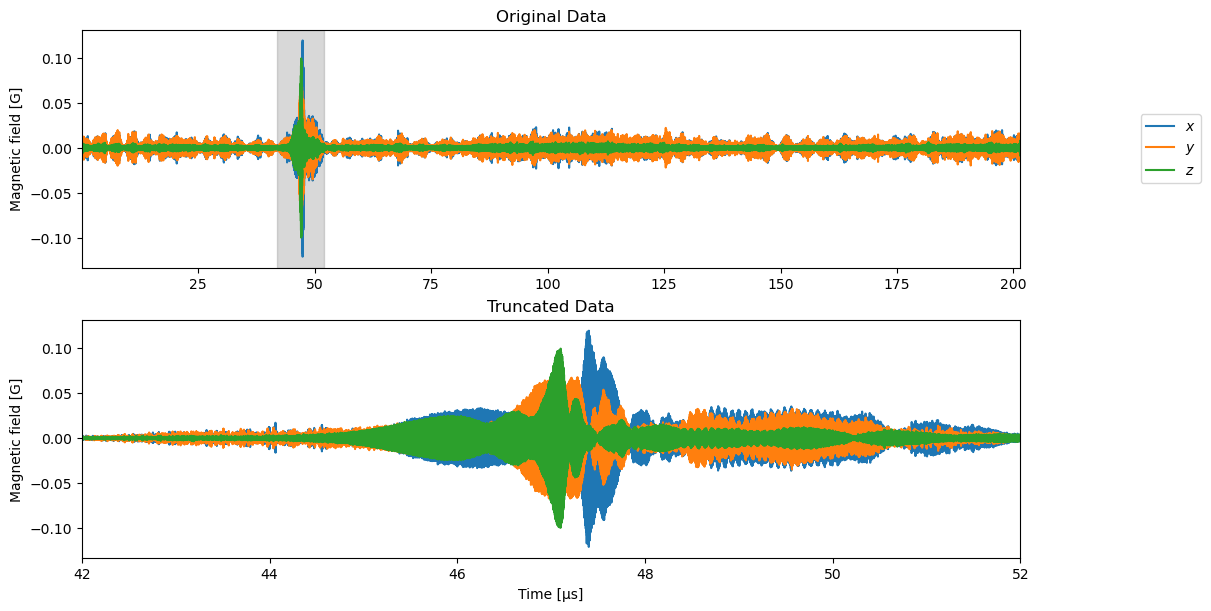

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_b(tt, bx, by, bz, start_time=None, end_time=None, returnvalue = True):
    fig, axs = plt.subplots(2, 1, figsize=[12,6], sharex=False, constrained_layout=True)
    tfactor = 1e6
    
    # Plot original data on the first subplot
    axs[0].plot(tt*tfactor, bx, label=r'$x$')
    axs[0].plot(tt*tfactor, by, label=r'$y$')
    axs[0].plot(tt*tfactor, bz, label=r'$z$')
    axs[0].set_xlim([tt[0]*tfactor, tt[-1]*tfactor])
    axs[0].set_ylabel('Magnetic field [G]')
    axs[0].legend(ncol=1, loc='center right', bbox_to_anchor=(1.2,0.5))
    axs[0].set_title('Original Data')
    
    # Truncate data for the second subplot
    if start_time is not None or end_time is not None:
        
        mask = (tt * 1e6 >= start_time) & (tt * 1e6 <= end_time)
        t_trunc, bx_trunc, by_trunc, bz_trunc = tt[mask], bx[mask], by[mask], bz[mask]
        axs[0].axvspan(start_time, end_time , color='grey', alpha=0.3, label='Selected Time Range')
    else:
        t_trunc, bx_trunc, by_trunc, bz_trunc = tt, bx, by, bz
        
        

    # Plot truncated data on the second subplot
    axs[1].plot(t_trunc*tfactor, bx_trunc, label=r'$x$')
    axs[1].plot(t_trunc*tfactor, by_trunc, label=r'$y$')
    axs[1].plot(t_trunc*tfactor, bz_trunc, label=r'$z$')
    axs[1].set_xlim([start_time, end_time] if start_time is not None or end_time is not None else [tt[0]*tfactor, tt[-1]*tfactor])
    axs[1].set_ylabel('Magnetic field [G]')
    axs[1].set_xlabel('Time [μs]')
    #axs[1].legend(ncol=1, loc='center right', bbox_to_anchor=(1.2,0.5))
    axs[1].set_title('Truncated Data')

    plt.show()
    if returnvalue:
        return t_trunc, bx_trunc, by_trunc,bz_trunc
    

# Example usage:
t_trunc, bx_trunc, by_trunc,bz_trunc = plot_b(tt, bx, by, bz,start_time = 42, end_time = 52)


In [4]:
data = read_lapd_data(filepath, rchan=[0, 1, 2], rshot=[6], xrange=[20], yrange=[8])

# Not sure how to get this one, remember to ask Xin!

area = [1.889e-1, 1.843e-1, 1.501e-1]

fs = 1.0 / data['dt'][0]
lowcut = 1.5e8
highcut = 1e9
bx = emf2bw(np.squeeze(data['data'])[:, 0], area[0], \
        lowcut, highcut, fs, rm_radio=1)
by = emf2bw(np.squeeze(data['data'])[:, 1], area[1], \
        lowcut, highcut, fs, rm_radio=1)
bz = emf2bw(np.squeeze(data['data'])[:, 2], area[2], \
        lowcut, highcut, fs, rm_radio=1)


# truncate time series at the beginning and end sections
ntrunc = 100
bx = bx[ntrunc:-ntrunc]
by = by[ntrunc:-ntrunc]
bz = bz[ntrunc:-ntrunc]
tt = data['time'][ntrunc:-ntrunc]


# Number of points in FFT
nopfft = 1024
# The amount of overlap between successive FFT intervals
steplength = nopfft / 2
# No. of bins in frequency domain for averaging [1, 7]
bin_freq = 7

result = pyspedas.analysis.twavpol.wavpol(tt, bx, by, bz, nopfft=nopfft, steplength=steplength, bin_freq=bin_freq)
(timeline, freqline, powspec, degpol, waveangle,
        elliptict, helict, pspec3, err_flag) = result



Reading data from motion list XY[2]: Ta_paddle
Reading motion list from module:  6K Compumotor
No 3302 boards used.
SIS 3305 boards used = [1, 2]
SIS 3305 effective clock rate: Board 1 = 5000.0 MHz
SIS 3305 effective clock rate: Board 2 = 5000.0 MHz
---------- SIS 3305 list of enabled channels (4) ----------
[ 0] Board 1, Channel 1: Bx-P25mov
[ 1] Board 1, Channel 5: By-P25mov
[ 2] Board 2, Channel 1: Bz-P25mov
[ 3] Board 2, Channel 5: By-P26fxd
------------------------------------------------------------
Reading SIS 3305...
------------------------------------------------------------
Data geometry = xy-plane
Read Channels = 0   1   2
Shot range    = 6 to 6
X value range = 20 to 20
Y value range = 8 to 8
 (xx/yy/zz/shots/steps/chan) = (1/1/1/1/1/1) of (1/1/1/1/1/3)1 1
Reading config name /Raw data + config/SIS crate/siscf0-4ch-5GHz-1Mpnts-200us [Slot 13: SIS 3305 FPGA 1 ch 1]
 (xx/yy/zz/shots/steps/chan) = (1/1/1/1/1/2) of (1/1/1/1/1/3)1 5
Reading config name /Raw data + config/SIS cra

04-Apr-24 11:31:46: wavpol Warning: file sampling frequency changes from 4999999999.999955Hz to 4999999999.650224Hz
04-Apr-24 11:31:46: n_batches: 1
04-Apr-24 11:31:46: Total number of steps:1968
04-Apr-24 11:31:46: Total number of possible FFT in the batch no 0 is:1967.0
04-Apr-24 11:31:46: wavpol step: 0 
04-Apr-24 11:31:55: wavpol step: 40 
04-Apr-24 11:32:03: wavpol step: 80 
04-Apr-24 11:32:12: wavpol step: 120 
04-Apr-24 11:32:20: wavpol step: 160 
04-Apr-24 11:32:29: wavpol step: 200 
04-Apr-24 11:32:37: wavpol step: 240 
04-Apr-24 11:32:46: wavpol step: 280 
04-Apr-24 11:32:54: wavpol step: 320 
04-Apr-24 11:33:03: wavpol step: 360 
04-Apr-24 11:33:12: wavpol step: 400 
04-Apr-24 11:33:20: wavpol step: 440 
04-Apr-24 11:33:29: wavpol step: 480 
04-Apr-24 11:33:38: wavpol step: 520 
04-Apr-24 11:33:47: wavpol step: 560 
04-Apr-24 11:33:55: wavpol step: 600 
04-Apr-24 11:34:04: wavpol step: 640 
04-Apr-24 11:34:13: wavpol step: 680 
04-Apr-24 11:34:21: wavpol step: 720 
04-Apr-24

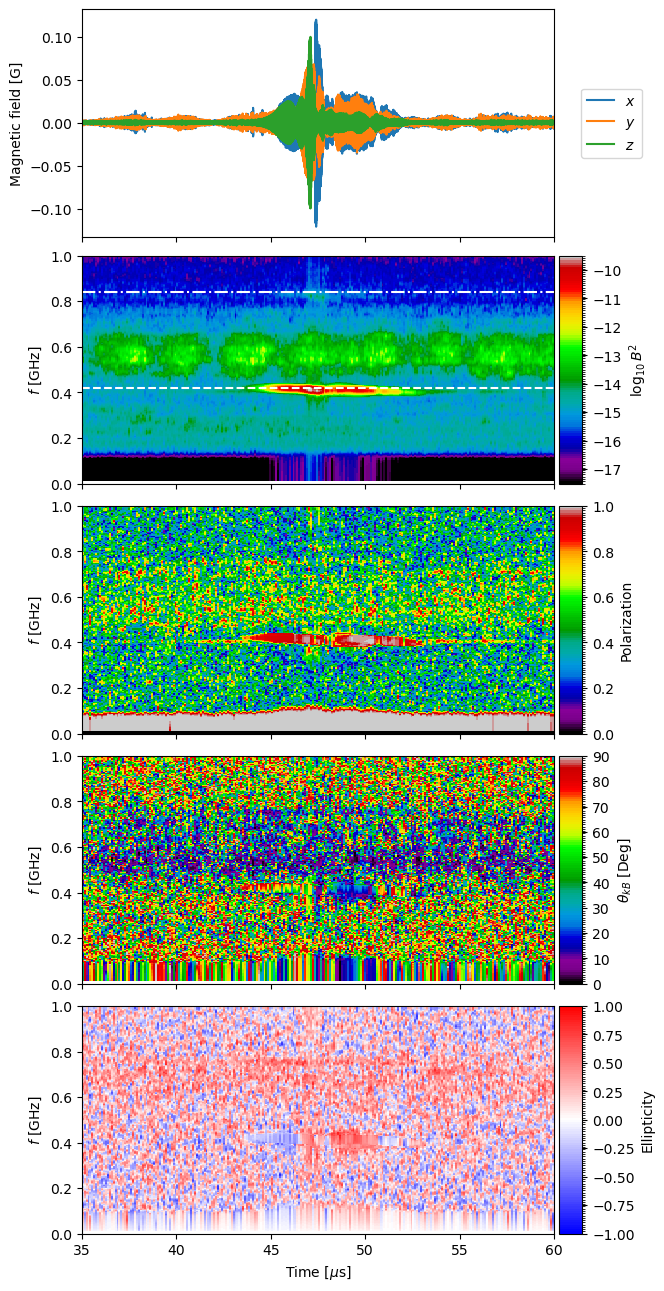

In [19]:
# make the figure

import pickle
from read_lapd import read_lapd_data
from bdot_process import emf2bw_areav
import numpy as np
import matplotlib.pyplot as plt
import pyspedas
from matplotlib import ticker, colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
from bdot_process import emf2bw
import os

def gauss_to_tesla_to_gyrofrequency(B_gauss):

    e = 1.602e-19  # Elementary charge, in Coulombs
    m_e = 9.109e-31  # Electron mass, in kg
    
    # Conversion factor from Gauss to Tesla
    gauss_to_tesla = 1e-4
    
    # Convert Gauss to Tesla
    B_tesla = B_gauss * gauss_to_tesla
    
    # Calculate electron gyrofrequency
    f = e * B_tesla / (2 * np.pi * m_e)
    
    return f

fce = gauss_to_tesla_to_gyrofrequency(300)

fig, axs = plt.subplots(5, 1, figsize=[6.4, 12.8],\
        sharex=True, constrained_layout=True)
tfactor = 1e6
tgrid, fgrid = np.meshgrid(timeline, freqline)
ax = axs[0]
ax.plot(tt*tfactor, bx, label=r'$x$')
ax.plot(tt*tfactor, by, label=r'$y$')
ax.plot(tt*tfactor, bz, label=r'$z$')
#ax.set_xlim([tt[0]*tfactor, tt[-1]*tfactor])
ax.set_xlim([35, 60])
ax.set_ylabel(r'Magnetic field [G]')
ax.legend(ncol=1, loc='center right', bbox_to_anchor=(1.2,0.5))


cmap = plt.get_cmap('nipy_spectral')
logpow = np.log10(powspec)
vmax = np.max(logpow)
vmin = vmax - 8
vlvs = np.linspace(vmin, vmax, 101)
norm = colors.BoundaryNorm(vlvs, ncolors=cmap.N)
im = axs[1].pcolormesh(tgrid*tfactor, fgrid/1e9, logpow.T, cmap=cmap, norm=norm, shading = 'nearest')
axs[1].set_ylim([0, highcut/1e9])
axs[1].set_ylabel(r'$f$ [GHz]')
axs[1].axhline(y = fce/1e9,xmin = 0,xmax = 60,color = 'white',linestyle = '-.')
axs[1].axhline(y = fce/1e9/2,xmin = 0,xmax = 60,color = 'white',linestyle = '--')

# colorbar
l = ticker.AutoLocator()
l.create_dummy_axis()
ticks = l.tick_values(vmin, vmax)
axins = inset_axes(axs[1], width="5%", height="100%", loc='lower left',\
        bbox_to_anchor=(1.01, 0, 1, 1), bbox_transform=axs[1].transAxes,\
        borderpad=0)
cb = fig.colorbar(im, cax=axins, ticks=ticks, orientation='vertical')
cb.ax.set_ylabel(r'$\log_{10} B^2$')

cmap = plt.get_cmap('nipy_spectral')
vmax = 1
vmin = 0
vlvs = np.linspace(vmin, vmax, 101)
norm = colors.BoundaryNorm(vlvs, ncolors=cmap.N)
im = axs[2].pcolormesh(tgrid*tfactor, fgrid/1e9, degpol.T, cmap=cmap, norm=norm,shading = 'nearest')
axs[2].set_ylim([0, highcut/1e9])
axs[2].set_ylabel(r'$f$ [GHz]')
# colorbar
l = ticker.AutoLocator()
l.create_dummy_axis()
ticks = l.tick_values(vmin, vmax)
axins = inset_axes(axs[2], width="5%", height="100%", loc='lower left',\
        bbox_to_anchor=(1.01, 0, 1, 1), bbox_transform=axs[2].transAxes,\
        borderpad=0)
cb = fig.colorbar(im, cax=axins, ticks=ticks, orientation='vertical')
cb.ax.set_ylabel('Polarization')
cb.formatter.set_powerlimits((0, 0))
cb.update_ticks()



ax = axs[3]
cmap = plt.get_cmap('nipy_spectral')
vmax = 90
vmin = 0
vlvs = np.linspace(vmin, vmax, 101)
norm = colors.BoundaryNorm(vlvs, ncolors=cmap.N)
im = ax.pcolormesh(tgrid*tfactor, fgrid/1e9, np.rad2deg(waveangle).T, cmap=cmap, norm=norm,shading = 'nearest')
ax.set_ylabel(r'$f$ [GHz]')
ax.set_ylim([0, highcut/1e9])
# colorbar
l = ticker.AutoLocator()
l.create_dummy_axis()
ticks = l.tick_values(vmin, vmax)
axins = inset_axes(ax, width="5%", height="100%", loc='lower left',\
        bbox_to_anchor=(1.01, 0, 1, 1), bbox_transform=ax.transAxes,\
        borderpad=0)
cb = fig.colorbar(im, cax=axins, ticks=ticks, orientation='vertical')
cb.ax.set_ylabel(r'$\theta_{kB}$ [Deg]')

ax = axs[4]
cmap = plt.get_cmap('bwr')
vmax = 1
vmin = -1
vlvs = np.linspace(vmin, vmax, 101)
norm = colors.BoundaryNorm(vlvs, ncolors=cmap.N)
im = ax.pcolormesh(tgrid*tfactor, fgrid/1e9, elliptict.T, cmap=cmap, norm=norm,shading = 'nearest')
ax.set_ylim([0, highcut/1e9])
ax.set_xlabel(r'Time [$\mu$s]')
ax.set_ylabel(r'$f$ [GHz]')
# colorbar
l = ticker.AutoLocator()
l.create_dummy_axis()
ticks = l.tick_values(vmin, vmax)
axins = inset_axes(ax, width="5%", height="100%", loc='lower left',\
        bbox_to_anchor=(1.01, 0, 1, 1), bbox_transform=ax.transAxes,\
        borderpad=0)
cb = fig.colorbar(im, cax=axins, ticks=ticks, orientation='vertical')
cb.ax.set_ylabel('Ellipticity')

plt.savefig('shot6_x20_y8_file04.png',dpi = 300)
plt.show()

In [9]:
def gauss_to_tesla_to_gyrofrequency(B_gauss):

    e = 1.602e-19  # Elementary charge, in Coulombs
    m_e = 9.109e-31  # Electron mass, in kg
    
    # Conversion factor from Gauss to Tesla
    gauss_to_tesla = 1e-4
    
    # Convert Gauss to Tesla
    B_tesla = B_gauss * gauss_to_tesla
    
    # Calculate electron gyrofrequency
    f = e * B_tesla / (2 * np.pi * m_e)
    
    return f

In [13]:
print(gauss_to_tesla_to_gyrofrequency(300)/1e9)

0.8397174843557461
